# Integer Linear Programming

## Introduction

In Integer Linear Programming (ILP), we seek to find a vector of integer numbers that maximizes (or minimizes) a linear cost function under a set of linear equality or inequality constraints [[1]](#ILP). In other words, it is an optimization problem where the cost function to be optimized and all the constraints are linear and the decision variables are integer.



## Mathematical Formulation
The ILP problem can be formulated as follows:

Given an $n$-dimensional vector $\vec{c} = (c_1, c_2, \ldots, c_n)$, an $m \times n$ matrix $A = (a_{ij})$ with $i=1,\ldots,m$ and $j=1,\ldots,n$, and an $m$-dimensional vector $\vec{b} = (b_1, b_2, \ldots, b_m)$, find an $n$-dimensional vector $\vec{x} = (x_1, x_2, \ldots, x_n)$ with integer entries that maximizes (or minimizes) the cost function:

\begin{align*}
\vec{c} \cdot \vec{x} = c_1x_1 + c_2x_2 + \ldots + c_nx_n
\end{align*}

subject to the constraints:

\begin{align*}
A \vec{x} & \leq \vec{b} \\
x_j & \geq 0, \quad j = 1, 2, \ldots, n \\
x_j & \in \mathbb{Z}, \quad j = 1, 2, \ldots, n
\end{align*}



# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
from typing import cast

import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
import numpy as np
import pyomo.core as pyo


def ilp(a: np.ndarray, b: np.ndarray, c: np.ndarray, bound: int) -> pyo.ConcreteModel:
    # model constraint: a*x <= b
    model = pyo.ConcreteModel()
    assert b.ndim == c.ndim == 1

    num_vars = len(c)
    num_constraints = len(b)

    assert a.shape == (num_constraints, num_vars)

    model.x = pyo.Var(
        # here we bound x to be from 0 to to a given bound
        range(num_vars),
        domain=pyo.NonNegativeIntegers,
        bounds=(0, bound),
    )

    @model.Constraint(range(num_constraints))
    def monotone_rule(model, idx):
        return a[idx, :] @ list(model.x.values()) <= float(b[idx])

    # model objective: max(c * x)
    model.cost = pyo.Objective(expr=c @ list(model.x.values()), sense=pyo.maximize)

    return model

In [3]:
A = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
b = np.array([1, 2, 3])
c = np.array([1, 2, 3])

# Instantiate the model
ilp_model = ilp(A, b, c, 4)

In [4]:
ilp_model.pprint()

2 Set Declarations
    monotone_rule_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}

1 Var Declarations
    x : Size=3, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     4 : False :  True : NonNegativeIntegers
          1 :     0 :  None :     4 : False :  True : NonNegativeIntegers
          2 :     0 :  None :     4 : False :  True : NonNegativeIntegers

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x[0] + 2*x[1] + 3*x[2]

1 Constraint Declarations
    monotone_rule : Size=3, Index=monotone_rule_index, Active=True
        Key : Lower : Body                     : Upper : Active
         

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [5]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [6]:
optimizer_config = OptimizerConfig(max_iteration=90, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [7]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=ilp_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [8]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [9]:
with open("integer_linear_programming.qmod", "w") as f:
    f.write(qmod)

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/2cbf7093-67af-4c6a-8add-e91029382696?version=0.38.0.dev42%2Bfd36e2c41c


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [11]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

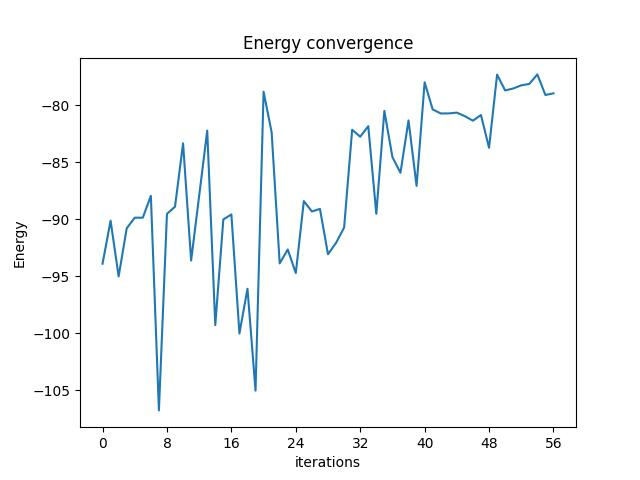

In [12]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [13]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    ilp_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)

optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
246,0.001,3.0,"[0, 0, 1]",1
57,0.003,2.0,"[0, 0, 2]",3
31,0.004,2.0,"[0, 0, 2]",4
312,0.001,1.0,"[0, 0, 1]",1
122,0.002,1.0,"[0, 0, 1]",2


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

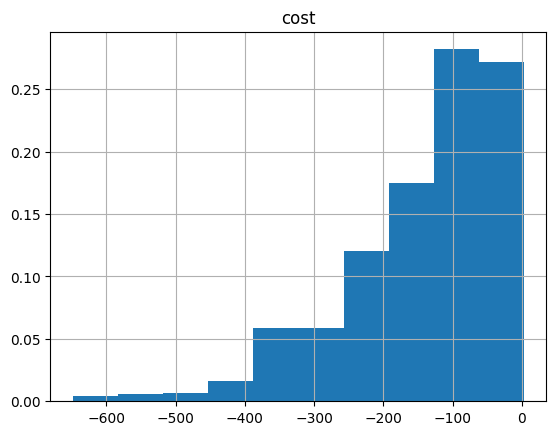

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the solution:

In [15]:
best_solution = optimization_result.solution[optimization_result.cost.idxmax()]
best_solution

[0, 0, 1]

## Comparison to a classical solver

Lastly, we can compare to the classical solution of the problem:

In [16]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(ilp_model)
classical_solution = [int(pyo.value(ilp_model.x[i])) for i in range(len(ilp_model.x))]
print("Classical solution:", classical_solution)

Classical solution: [0, 0, 1]



## References

<a id='MVC'>[1]</a>: [Integer Programming (Wikipedia).](https://en.wikipedia.org/wiki/Integer_programming)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
